
# Results for experiments over KDDCup dataset

In [1]:
%matplotlib inline
from IPython.display import display

import matplotlib.pyplot as plt
import numpy
import pandas
import pickle
import os
import re

from sklearn import metrics

In [2]:
import seaborn
seaborn.set_style('white')
seaborn.set_palette('colorblind')

In [3]:
METRICS_COLS = ['AUC', 'RMSE', 'Accuracy', 'R2']

In [4]:
def get_runs(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'prediction' in run_prediction]

def get_learning(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'performance' in run_prediction]

In [5]:
ANCHOR_COURSES = [1, 6, 16]

In [6]:
def read_predictions(filename):
    with open(filename, 'rb') as prediction_file:
        return pickle.load(prediction_file)

def read_file_metrics(true, predicted):
    """Returns a DataFrame with values AUC, RMSE, APS, Accuracy, R2 Score"""
    results = []
    ignored_sequences = 0
    try:
        results.append([metrics.roc_auc_score(true, predicted)])
    except ValueError:
        ignored_sequences += 1
        results.append([numpy.nan])
    results[-1].append(metrics.mean_squared_error(true, predicted)**0.5)
    results[-1].append(metrics.accuracy_score(true, numpy.where(predicted > 0.5, 1, 0)))
    results[-1].append(metrics.r2_score(true, predicted))
    results[-1].append(true.shape[0])
    if ignored_sequences > 0:    
        print('{} sequences with only one class, ignoring.'.format(ignored_sequences))
    return pandas.DataFrame(results, columns=METRICS_COLS + ['Support'])

In [7]:
def read_metrics(dirnames):
    metrics_dfs = []
    for dirname in dirnames:
        trues, predictions = [], []
        for filename in get_runs(dirname):
            true, predicted = read_predictions(os.path.join(dirname, filename))
            file_metrics = read_file_metrics(true, predicted)
            file_metrics['Experiment'] = dirname[-16:]
            file_metrics['Run'] = re.search('.*run(\d+).*', filename).group(1)
            course = re.search('.*_c(\d+)_.*', filename)
            if course is not None:
                file_metrics['Course'] = int(re.search('.*_c(\d+)_.*', filename).group(1))
            else:
                file_metrics['Course'] = 1
            metrics_dfs.append(file_metrics)
            trues.append(true)
            predictions.append(predicted)
        general_metrics = read_file_metrics(numpy.concatenate(trues), numpy.concatenate(predictions))
        general_metrics['Experiment'] = dirname[-16:]
        general_metrics['Run'] = -1
        general_metrics['Course'] = -1
        metrics_dfs.append(general_metrics)
    return pandas.concat(metrics_dfs, ignore_index=True).set_index(['Experiment', 'Run', 'Course'])

In [8]:
def read_performances(dirnames):
    results = {}
    for dirname in reversed(dirnames):
        dataframes = []
        for filename in get_learning(dirname):
            with open(os.path.join(dirname, filename), 'rb') as performance_file:
                train, validation = pickle.load(performance_file)
            train = pandas.DataFrame(train, columns=['epoch', 'mse'], dtype=numpy.float32)
            validation = pandas.DataFrame(validation, columns=['epoch', 'mse'], dtype=numpy.float32)
            train['Dataset'] = 'train'
            validation['Dataset'] = 'validation'
            concat = pandas.concat([train, validation])
            concat['Run'] = re.search('.*run(\d+).*', filename).group(1)
            course = re.search('.*_c(\d+)_.*', filename)
            if course is not None:
                concat['Course'] = int(re.search('.*_c(\d+)_.*', filename).group(1))
            else:
                concat['Course'] = 1
            concat['rmse'] = concat['mse']**0.5
            dataframes.append(concat)
        if len(dataframes) > 0:
            results[dirname] = pandas.concat(dataframes) # train.join(validation, lsuffix='_t', rsuffix='_v')
    return results

def graphic_performances(train_performances):
    for dirname, performance_dataframe in train_performances.items():
        print(dirname)
        performance_dataframe['epoch'] = performance_dataframe.epoch.astype(numpy.int)
        grid = seaborn.FacetGrid(data=performance_dataframe.loc[performance_dataframe['Run'] == '0'],
                                 col='Course', despine=True, ylim=[0, 0.5], aspect=1,
                                 palette='colorblind')
        mapped = grid.map(seaborn.pointplot, 'epoch', 'rmse', 'Dataset').add_legend().set_xticklabels([])
        plt.show()

### Real distribution of labels

In [32]:
true, predicted = read_predictions('/home/mteruel/edm/results/kddcup/lstm/predictions/18-01-04-12-39/predictions_c1_run0.p')
true.shape, true[true == 1].shape

((1700,), (1093,))

## Experiments with LSTM model

In [9]:
LSTM_EXPERIMENTS_DIRS = [
    #'/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-09-35/',
    '/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-19-47/',
    '/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-20-29/',
    '/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-20-38/',
    '/home/mteruel/edm/results/kddcup/lstm/predictions/18-01-04-12-39/',
]

## Learning curves

In [67]:
lstm_performances = read_performances(LSTM_EXPERIMENTS_DIRS)

/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-20-29/


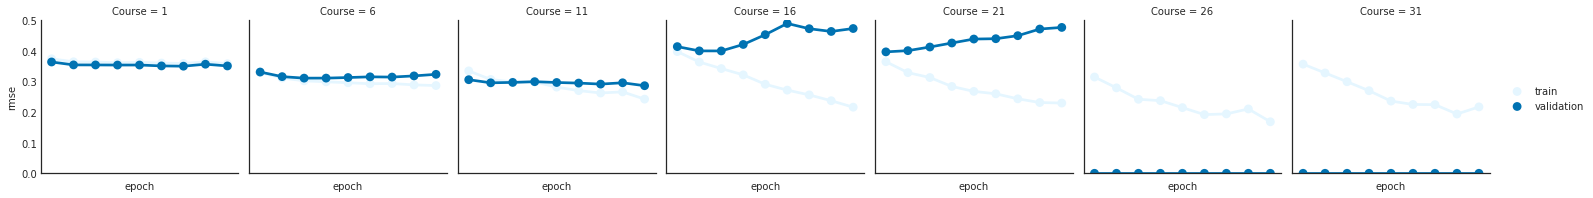

/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-19-47/


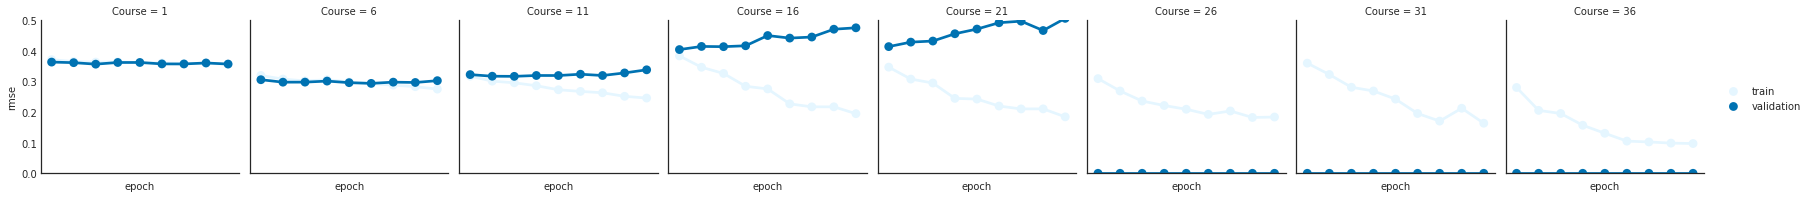

/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-20-38/


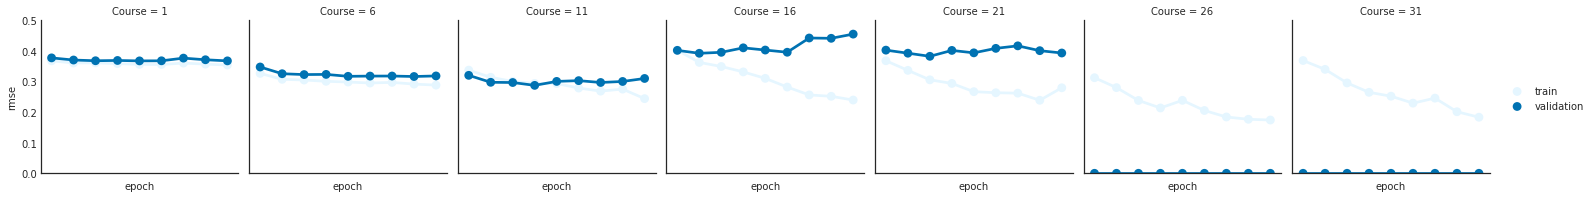

/home/mteruel/edm/results/kddcup/lstm/predictions/18-01-04-12-39/


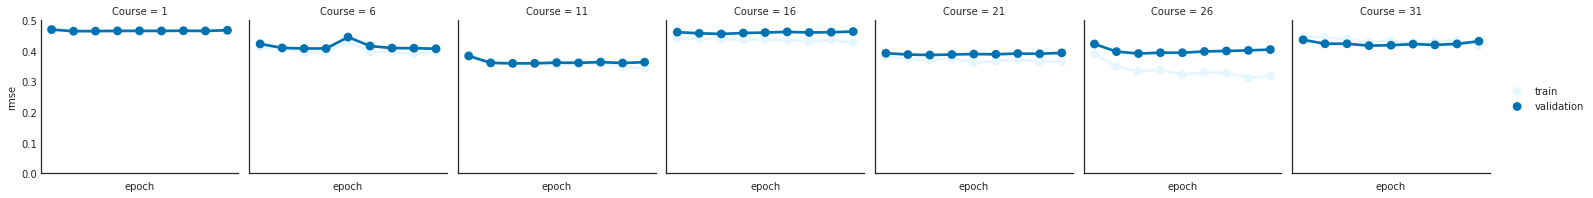

In [68]:
graphic_performances(lstm_performances)

In [ ]:
for dirname, dataframe in lstm_performances.items():
    print(dirname)
    idx = dataframe.groupby(['Dataset', 'Course'])['epoch'].transform(max) == dataframe['epoch']
    display(dataframe[idx].groupby(['Course', 'Dataset']).agg('mean'))

## Performance Metrics

In [69]:
lstm_metrics = read_metrics(LSTM_EXPERIMENTS_DIRS)

In [74]:
lstm_metrics.groupby(['Experiment', 'Course']).aggregate('mean')[METRICS_COLS]

AUC      RMSE  Accuracy        R2
Experiment       Course                                        
/17-12-21-19-47/ -1      0.791391  0.383026  0.820270  0.260302
                  1      0.878725  0.358683  0.830588  0.438937
                  6      0.793712  0.344677  0.850000  0.274631
                  11     0.757309  0.348093  0.853750  0.104003
                  16     0.605285  0.532721  0.671667 -0.307955
                  21     0.497556  0.456182  0.770000 -0.430692
                  26     0.517241  0.331975  0.890000  0.025567
                  31     0.635832  0.495192  0.745000 -0.331887
                  36     0.728261  0.302985  0.905000 -0.260744
/17-12-21-20-29/ -1      0.811344  0.375036  0.821944  0.300408
                  1      0.880297  0.359114  0.826765  0.438206
                  6      0.801927  0.338676  0.857857  0.296198
                  11     0.766045  0.348505  0.847500  0.117414
                  16     0.656103  0.511274  0.685000 -0.183175
                  21     0.596916  0.414426  0.800000 -0.198924
                  26     0.579420  0.309793  0.885000 -0.032537
                  31     0.675837  0.425695  0.800000  0.045381
/17-12-21-20-38/ -1      0.814149  0.373602  0.821944  0.308482
                  1      0.881006  0.361324  0.822059  0.430561
                  6      0.803861  0.335795  0.863571  0.314949
                  11     0.738556  0.357680  0.837500  0.108718
                  16     0.666461  0.490281  0.713333 -0.108186
                  21     0.626165  0.404719  0.795000 -0.094339
                  26     0.674197  0.272854  0.920000  0.198244
                  31     0.699818  0.463802  0.775000 -0.062171
/18-01-04-12-39/ -1      0.703205  0.447162  0.689600 -0.002751
                  1      0.759349  0.466593  0.616765  0.049575
                  6      0.657383  0.415346  0.783571 -0.053189
                  11     0.602647  0.399738  0.792222 -0.183215
                  16     0.611278  0.500376  0.613333 -0.164023
                  21     0.633873  0.398126  0.783333 -0.073964
                  26     0.556448  0.397405  0.786667 -0.439225
                  31     0.588946  0.514483  0.636667 -0.334524

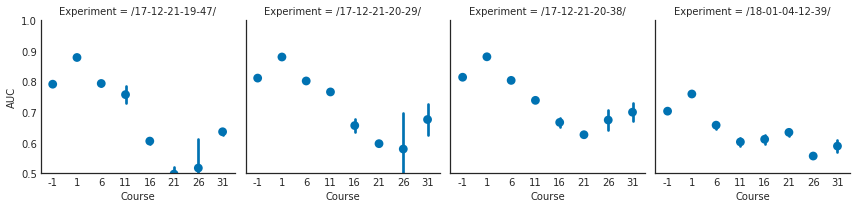

In [41]:
grid = seaborn.FacetGrid(data=lstm_metrics.reset_index(), col='Experiment', col_wrap=4, ylim=[0.5, 1])
grid.map(seaborn.pointplot, 'Course', 'AUC', join=False)

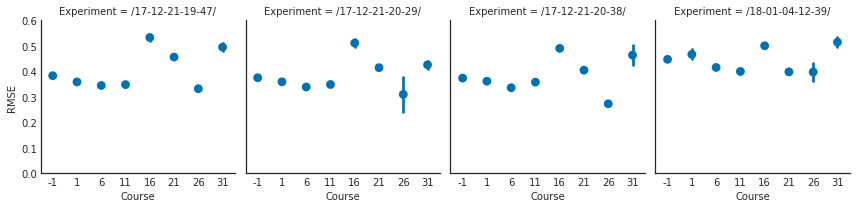

In [42]:
grid = seaborn.FacetGrid(data=lstm_metrics.reset_index(), col='Experiment', col_wrap=4, ylim=[0, 0.6])
grid.map(seaborn.pointplot, 'Course', 'RMSE', join=False)

## Experiments with Embedded LSTM model

In [10]:
EMBEDDING_EXPERIMENTS_DIRS = [
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-09-51/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-09-59/',
#      '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-10-02/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-10-59/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-11-05/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-19-28/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-21-04/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/18-01-03-17-53/',
#     '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-03-10-28/',
    '/home/mteruel/edm/results/kddcup/embedding/predictions/18-01-09-20-33/',
    '/home/mteruel/edm/results/kddcup/embedding/predictions/18-01-09-20-49/',
    '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-10-14-15/',
    '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-10-14-58/',
    '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-11-14-38/',
    '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-12-18-40/',
    '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-12-19-06/',
]

## Learning curves

In [11]:
embedding_performances = read_performances(EMBEDDING_EXPERIMENTS_DIRS)

/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-10-14-15/


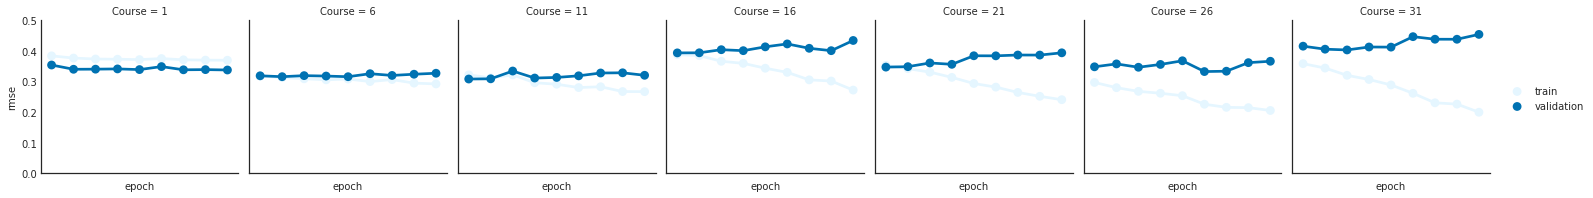

/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-12-19-06/


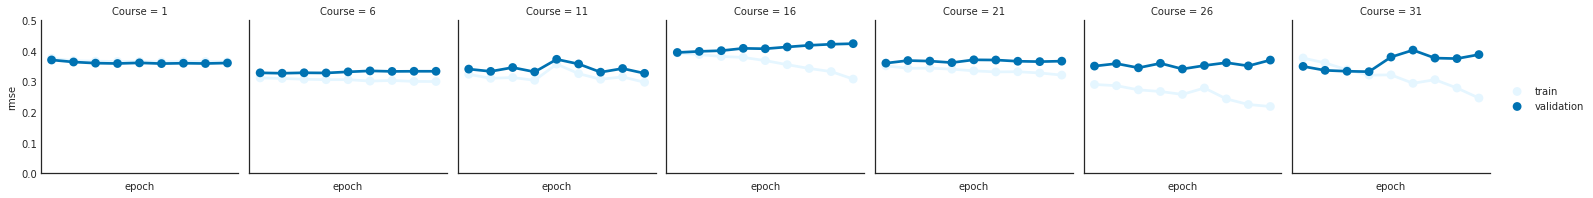

/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-11-14-38/


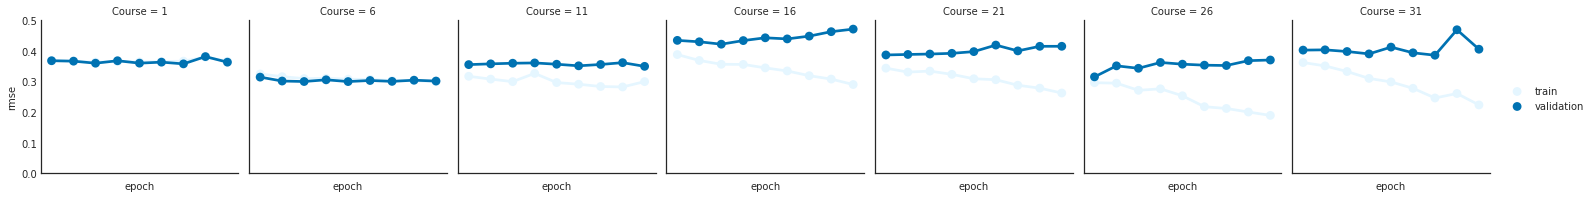

/home/mteruel/edm/results/kddcup/embedding/predictions/18-01-09-20-49/


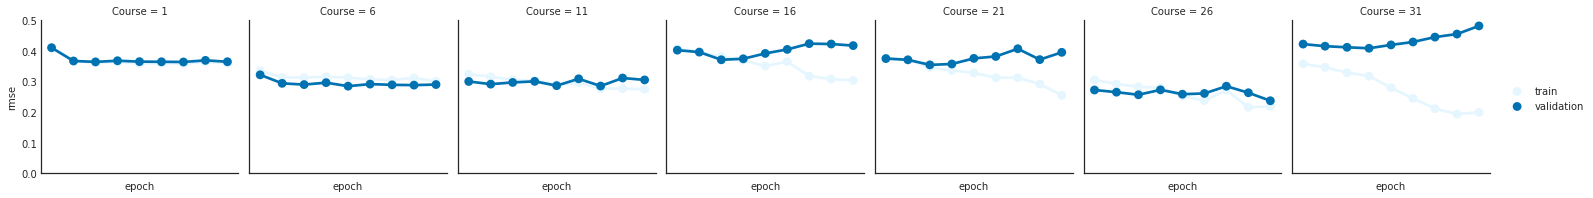

/home/mteruel/edm/results/kddcup/embedding/predictions/18-01-09-20-33/


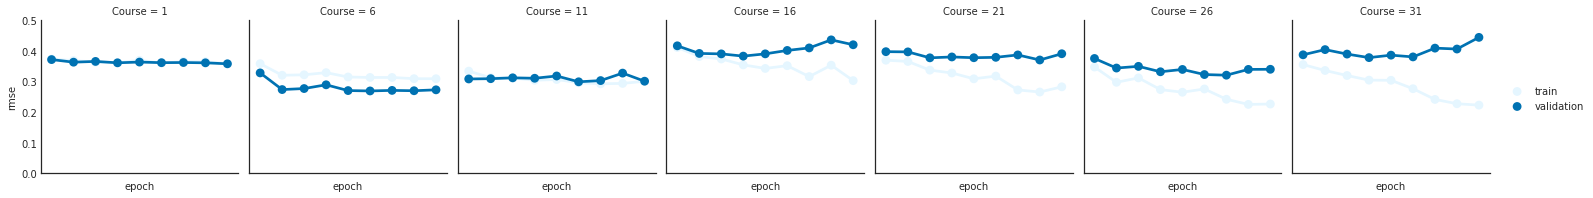

/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-10-14-58/


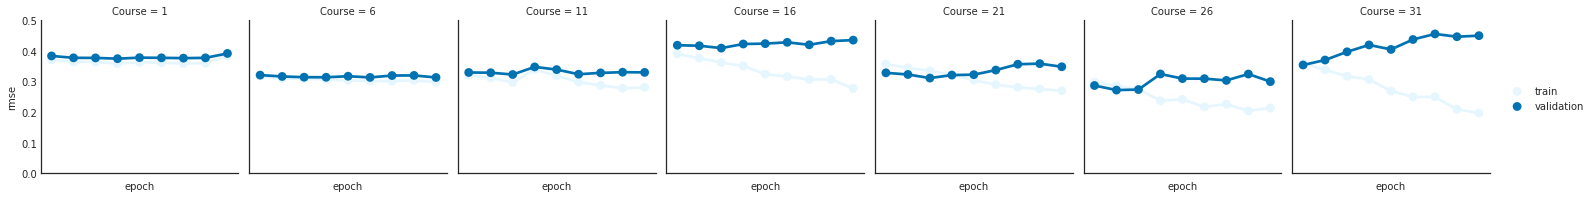

/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-12-18-40/


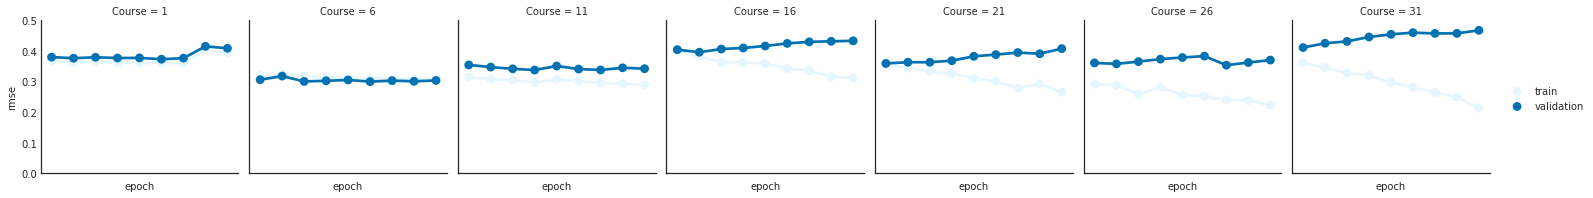

In [12]:
graphic_performances(embedding_performances)

## Performance Metrics

In [13]:
embedding_metrics = read_metrics(EMBEDDING_EXPERIMENTS_DIRS)

In [14]:
embedding_metrics.groupby(['Experiment', 'Course']).aggregate('mean')[METRICS_COLS]

AUC      RMSE  Accuracy        R2
Experiment       Course                                        
/18-01-09-20-33/ -1      0.830116  0.362789  0.831065  0.339042
                  1      0.884142  0.357248  0.829793  0.443197
                  6      0.810134  0.334122  0.867527  0.318745
                  11     0.783163  0.329591  0.858672  0.194120
                  16     0.739729  0.454947  0.726852  0.050329
                  21     0.685426  0.378987  0.814516  0.028864
                  26     0.649126  0.308800  0.892638  0.112278
                  31     0.741849  0.443762  0.774510  0.009007
/18-01-09-20-49/ -1      0.834144  0.361494  0.829268  0.343754
                  1      0.883644  0.357592  0.824627  0.442151
                  6      0.812601  0.333291  0.864810  0.322126
                  11     0.786582  0.327041  0.859743  0.206551
                  16     0.730769  0.455922  0.714506  0.042911
                  21     0.687500  0.374792  0.830645  0.050737
                  26     0.580944  0.327380  0.880368  0.003249
                  31     0.791613  0.410934  0.803922  0.150646
/18-01-10-14-15/ -1      0.808452  0.377522  0.816175  0.284271
                  1      0.871491  0.365455  0.816303  0.417388
                  6      0.801099  0.343638  0.845788  0.279383
                  11     0.764303  0.352184  0.843683  0.079906
                  16     0.701093  0.479159  0.711420 -0.053461
                  21     0.574663  0.407497  0.812903 -0.121969
                  26     0.553671  0.331838  0.874233 -0.023022
                  31     0.700879  0.470061  0.754902 -0.109553
/18-01-10-14-58/ -1      0.818096  0.370313  0.822721  0.311344
                  1      0.879250  0.359486  0.825201  0.436263
                  6      0.788358  0.339548  0.860734  0.296441
                  11     0.760629  0.348673  0.840471  0.098163
                  16     0.706709  0.471096  0.711420 -0.018275
                  21     0.671928  0.388273  0.811290 -0.020515
                  26     0.613636  0.322322  0.883436  0.032559
                  31     0.688546  0.454548  0.751634 -0.039350
/18-01-11-14-38/ -1      0.825062  0.365453  0.829653  0.329299
                  1      0.875139  0.364697  0.827497  0.419764
                  6      0.806000  0.338295  0.853940  0.301574
                  11     0.780272  0.324598  0.868308  0.218179
                  16     0.714358  0.448738  0.739198  0.076098
                  21     0.649712  0.383389  0.824194  0.006925
                  26     0.621678  0.307376  0.895706  0.121884
                  31     0.739597  0.433412  0.751634  0.054162
/18-01-12-18-40/ -1      0.831471  0.362727  0.829397  0.339268
                  1      0.879170  0.360530  0.826636  0.432939
                  6      0.814911  0.334772  0.857337  0.316091
                  11     0.780527  0.321334  0.867238  0.233784
                  16     0.733392  0.437555  0.742284  0.121507
                  21     0.675091  0.380813  0.825806  0.019743
                  26     0.615210  0.302658  0.895706  0.148806
                  31     0.693801  0.466581  0.732026 -0.094497
/18-01-12-19-06/ -1      0.834928  0.361778  0.827086  0.342723
                  1      0.879839  0.360713  0.822044  0.432409
                  6      0.814511  0.340267  0.846467  0.293432
                  11     0.774813  0.322827  0.872591  0.226761
                  16     0.722487  0.445336  0.736111  0.088709
                  21     0.712247  0.371045  0.822581  0.069070
                  26     0.693531  0.304827  0.892638  0.135853
                  31     0.757722  0.420008  0.784314  0.113790

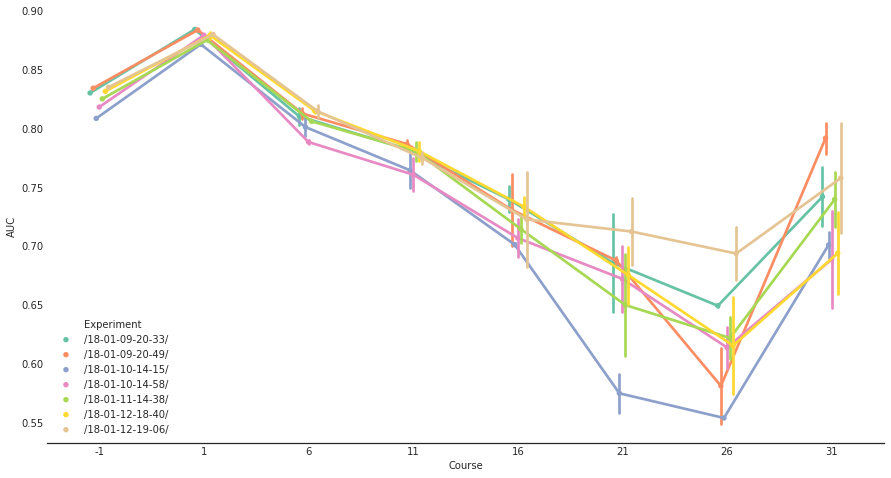

In [15]:
plt.subplots(figsize=(15,8))
seaborn.pointplot(data=embedding_metrics.reset_index(), x='Course', y='AUC', hue='Experiment',
                  dodge=True, palette="Set2", markers=".")
seaborn.despine(left=True)

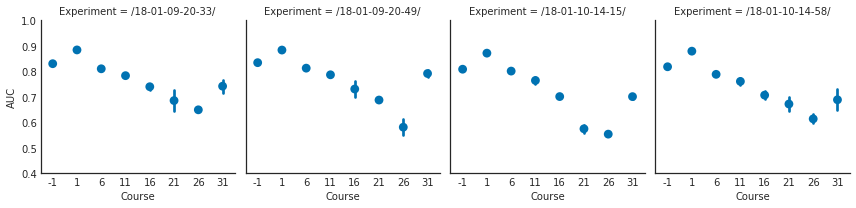

In [54]:
grid = seaborn.FacetGrid(data=embedding_metrics.reset_index(), col='Experiment', col_wrap=4, ylim=[0.4, 1])
grid.map(seaborn.pointplot, 'Course', 'AUC', join=False)

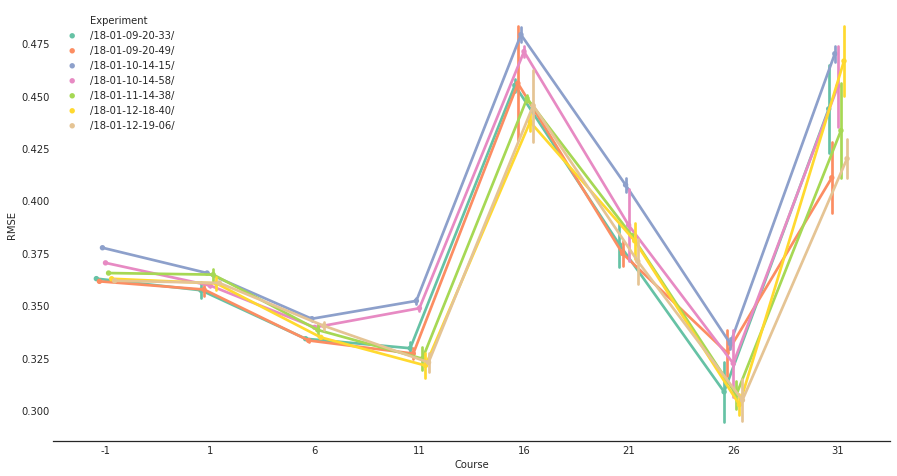

In [16]:
plt.subplots(figsize=(15,8))
seaborn.pointplot(data=embedding_metrics.reset_index(), x='Course', y='RMSE', hue='Experiment',
                  dodge=True, palette="Set2", markers=".")
seaborn.despine(left=True)

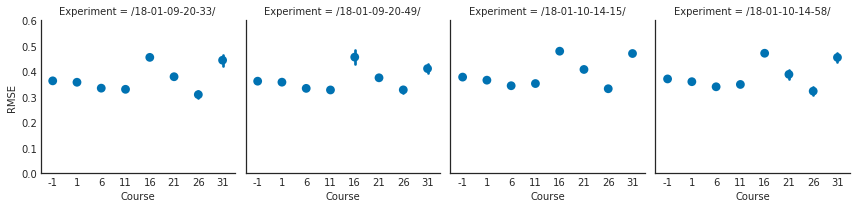

In [40]:
grid = seaborn.FacetGrid(data=embedding_metrics.reset_index(), col='Experiment', col_wrap=4, ylim=[0, 0.6])
grid.map(seaborn.pointplot, 'Course', 'RMSE', join=False)

## Experiments with CO-Embedde LSTM model

In [19]:
COEMBEDDING_EXPERIMENTS_DIRS = [
    #'/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-12-09/',
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-12-57/',
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-20-56/',
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-21-13/',
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-21-22/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-03-12-22/',
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-04-09-45/',
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-05-17-37/',
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-09-18-19/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-09-18-46/',
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-09-20-18/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-10-14-18/',
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-10-23-03/',
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-11-16-32/',
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-12-09-49/',
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-12-10-31/',
]

## Learning curves

In [20]:
coembedding_performances = read_performances(COEMBEDDING_EXPERIMENTS_DIRS)

/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-10-23-03/


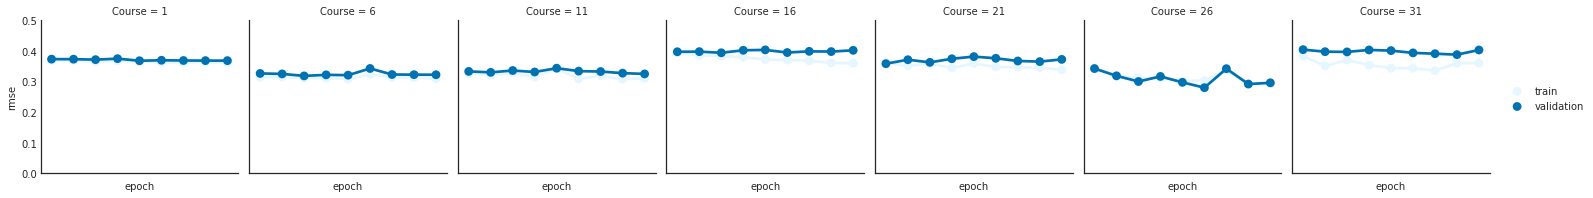

/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-11-16-32/


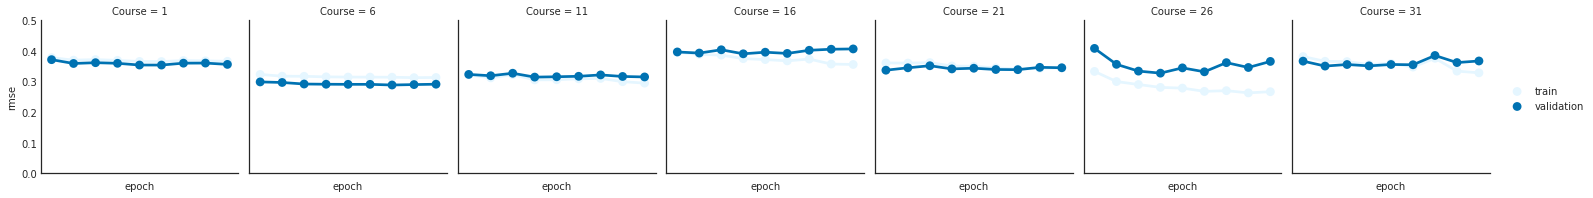

/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-09-18-19/


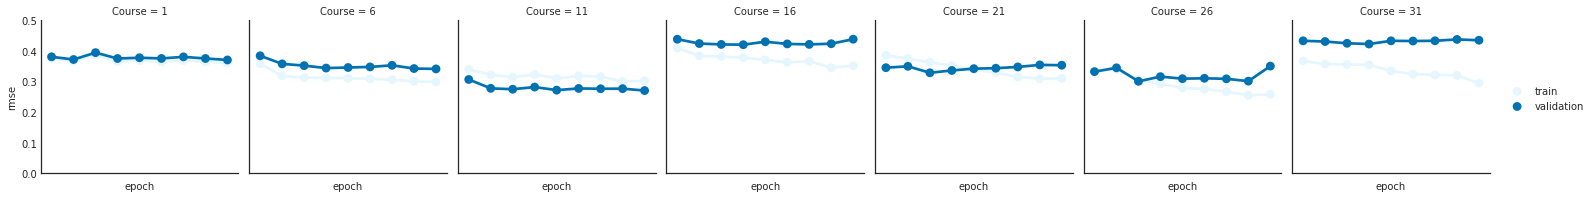

/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-12-09-49/


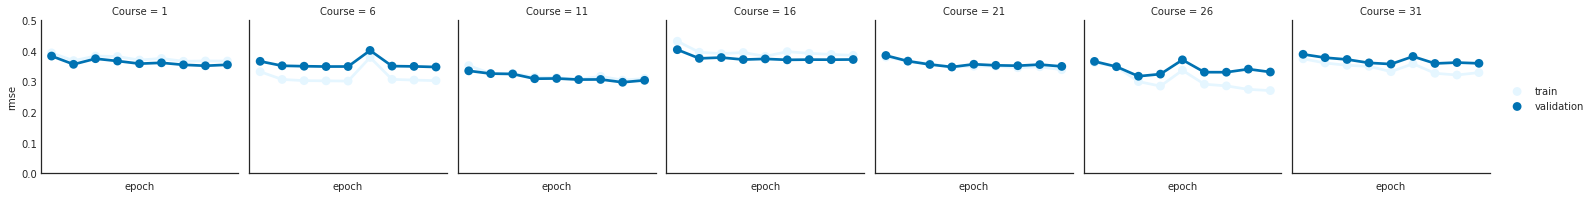

/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-09-20-18/


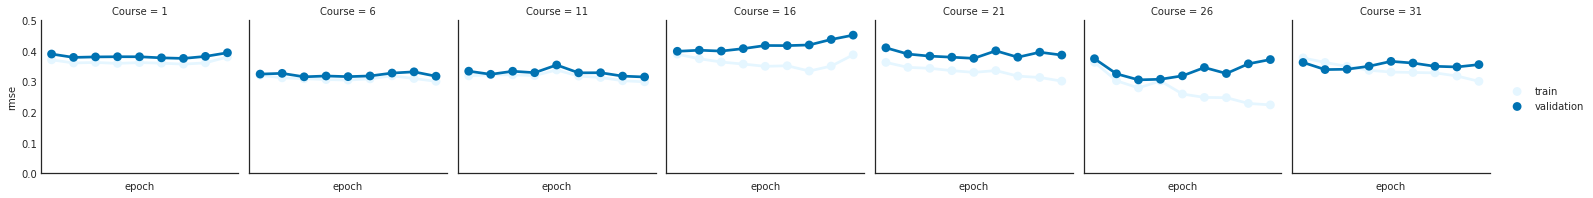

/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-12-10-31/


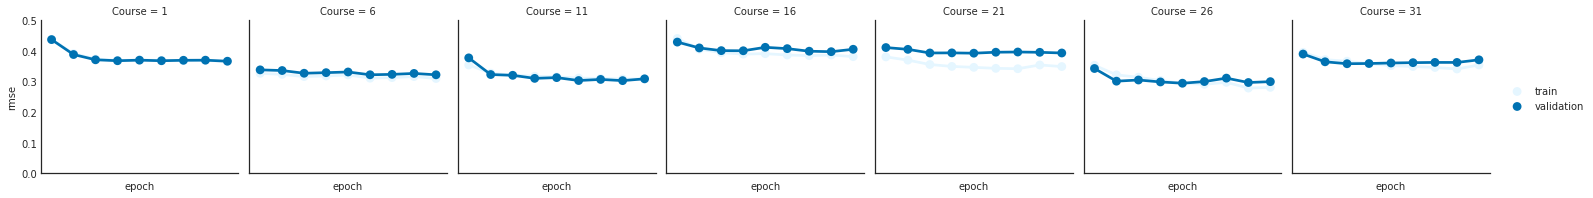

In [21]:
graphic_performances(coembedding_performances)

## Performance Metrics

In [22]:
coembedding_metrics = read_metrics(COEMBEDDING_EXPERIMENTS_DIRS)

In [23]:
coembedding_metrics.groupby(['Experiment', 'Course']).aggregate('mean')

AUC      RMSE  Accuracy        R2  Support
Experiment       Course                                                 
/18-01-09-18-19/ -1      0.841096  0.360392  0.827343  0.347749     7790
                  1      0.880747  0.358434  0.821470  0.439555     1742
                  6      0.825230  0.336651  0.855978  0.308393      736
                  11     0.786310  0.332500  0.858672  0.179882      467
                  16     0.751967  0.448658  0.733025  0.076001      324
                  21     0.679064  0.377748  0.824194  0.034786      310
                  26     0.721853  0.301481  0.898773  0.153840      163
                  31     0.829794  0.384266  0.790850  0.256425      153
/18-01-09-20-18/ -1      0.841084  0.358375  0.827728  0.355029     7790
                  1      0.880692  0.356945  0.828358  0.444152     1742
                  6      0.810016  0.344838  0.841712  0.273294      736
                  11     0.784014  0.321019  0.861884  0.235505      467
                  16     0.735795  0.436863  0.739198  0.123780      324
                  21     0.757979  0.361263  0.827419  0.118238      310
                  26     0.658042  0.302897  0.892638  0.146117      163
                  31     0.788825  0.405526  0.767974  0.173543      153
/18-01-10-23-03/ -1      0.843817  0.357996  0.831451  0.356392     7790
                  1      0.876899  0.364666  0.825201  0.419711     1742
                  6      0.817327  0.332207  0.864810  0.326526      736
                  11     0.779796  0.320291  0.872591  0.238962      467
                  16     0.734309  0.441519  0.725309  0.105543      324
                  21     0.775977  0.353376  0.820968  0.156183      310
                  26     0.729196  0.304099  0.892638  0.140768      163
                  31     0.837087  0.373665  0.797386  0.298908      153
/18-01-11-16-32/ -1      0.845243  0.357403  0.827471  0.358524     7790
                  1      0.880780  0.358051  0.825201  0.440752     1742
                  6      0.818848  0.336199  0.858696  0.310115      736
                  11     0.773810  0.328112  0.854390  0.201371      467
                  16     0.740166  0.435614  0.736111  0.128843      324
                  21     0.751441  0.361571  0.824194  0.116518      310
                  26     0.686364  0.304244  0.886503  0.139950      163
                  31     0.820142  0.392321  0.758170  0.226246      153
/18-01-12-09-49/ -1      0.850923  0.352285  0.835558  0.376761     7790
                  1      0.880606  0.356679  0.832090  0.445030     1742
                  6      0.812556  0.334801  0.859375  0.315947      736
                  11     0.769473  0.329762  0.864026  0.193021      467
                  16     0.771001  0.416382  0.751543  0.204462      324
                  21     0.787191  0.348344  0.837097  0.180162      310
                  26     0.802622  0.288014  0.892638  0.229384      163
                  31     0.854569  0.371763  0.787582  0.305972      153
/18-01-12-10-31/ -1      0.848024  0.356076  0.829012  0.363275     7790
                  1      0.876172  0.363383  0.824914  0.423972     1742
                  6      0.810731  0.331359  0.857337  0.329965      736
                  11     0.759065  0.335116  0.852248  0.166895      467
                  16     0.766455  0.419695  0.742284  0.191575      324
                  21     0.759280  0.356181  0.819355  0.142558      310
                  26     0.795629  0.273261  0.904908  0.306248      163
                  31     0.839339  0.378614  0.790850  0.279411      153

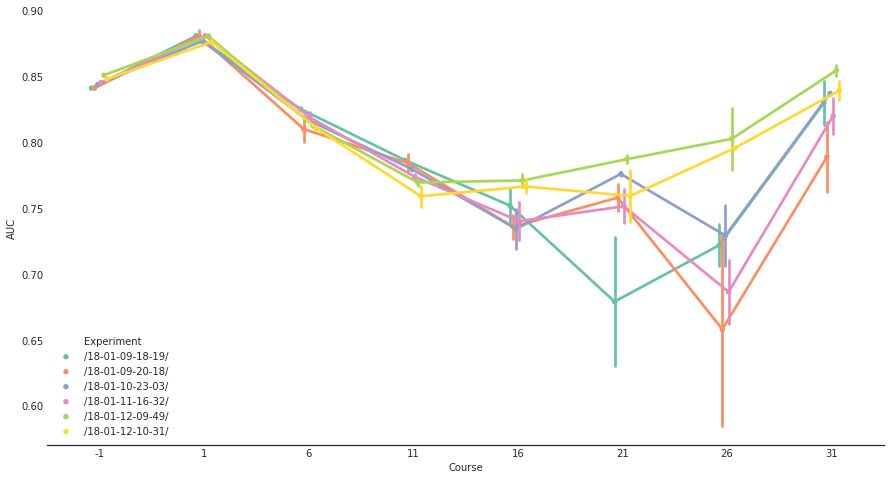

In [24]:
plt.subplots(figsize=(15,8))
seaborn.pointplot(data=coembedding_metrics.reset_index(), x='Course', y='AUC', hue='Experiment',
                  dodge=True, palette="Set2", markers=".")
seaborn.despine(left=True)

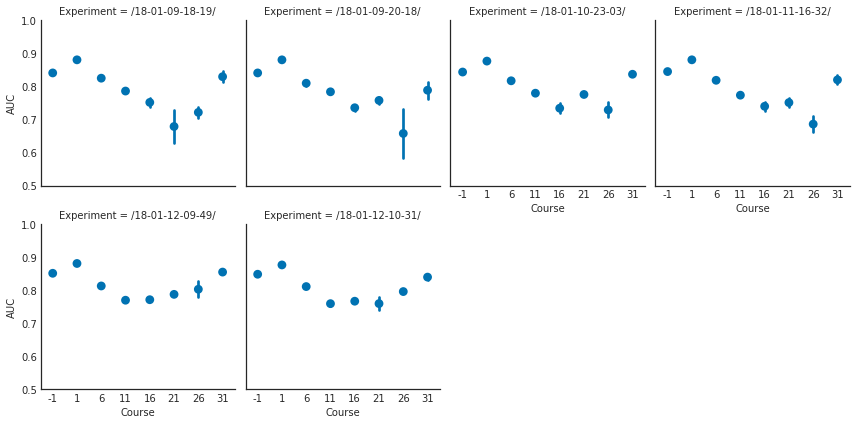

In [25]:
grid = seaborn.FacetGrid(data=coembedding_metrics.reset_index(), col='Experiment', ylim=[0.5, 1], col_wrap=4)
grid.map(seaborn.pointplot, 'Course', 'AUC', join=False)

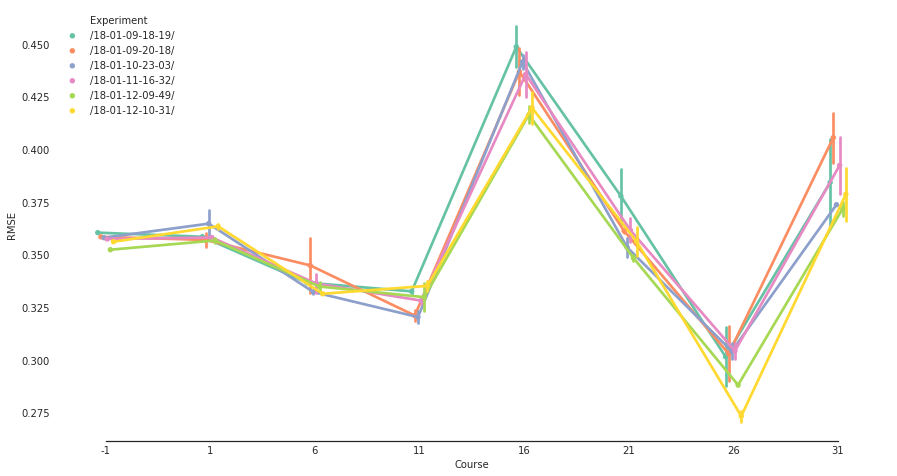

In [26]:
plt.subplots(figsize=(15,8))
seaborn.pointplot(data=coembedding_metrics.reset_index(), x='Course', y='RMSE', hue='Experiment',
                  dodge=True, palette="Set2", markers=".")
seaborn.despine(left=True, trim=True)

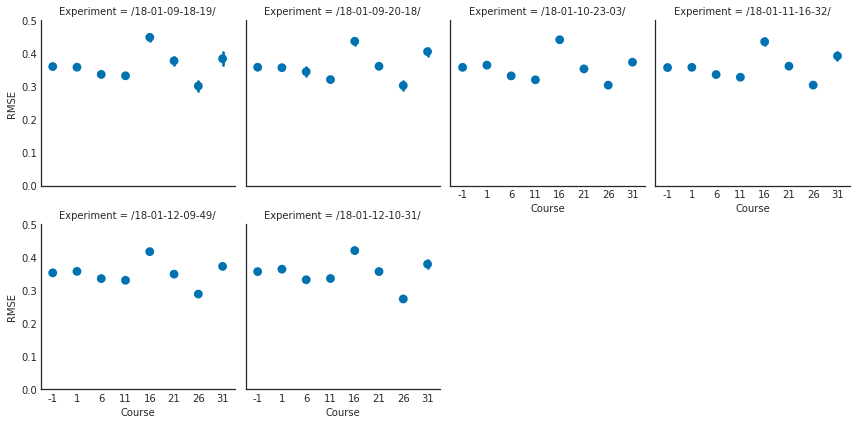

In [27]:
grid = seaborn.FacetGrid(data=coembedding_metrics.reset_index(), col='Experiment', ylim=[0, 0.5], col_wrap=4)
grid.map(seaborn.pointplot, 'Course', 'RMSE', join=False)